In [1]:
# Allow us to load `open_cp` without installing
import sys, os.path
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# The input data

Here we use the (not publically available) data for Chicago, which has we believe accurate geocoding.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import descartes
import os
import numpy as np
import descartes

import open_cp.sources.chicago as chicago
import open_cp.naive
import open_cp.geometry
import open_cp.plot

datadir = os.path.join("//media", "disk", "Data")
#datadir = os.path.join("..", "..", "..", "..", "..", "Data")

In [3]:
chicago.set_data_directory(datadir)
south_side = chicago.get_side("South")
points = chicago.load(os.path.join(datadir, "chicago_two.csv"), {"BURGLARY"}, type="all_other")

In [4]:
points.number_data_points, points.time_range

(61915,
 (numpy.datetime64('2010-09-13T14:30:00.000'),
  numpy.datetime64('2013-04-16T02:30:00.000')))

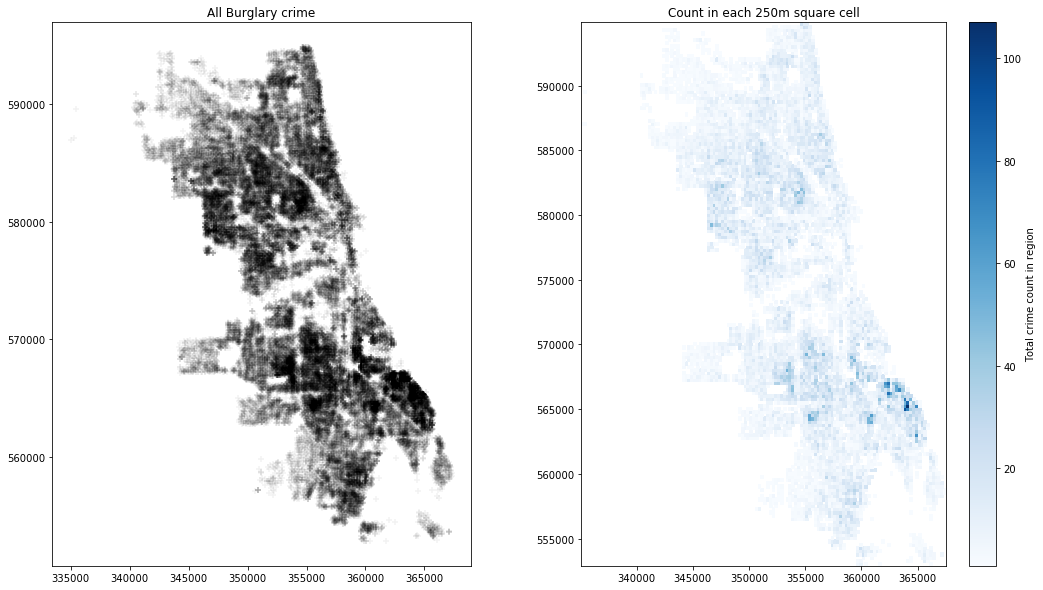

In [5]:
fig, ax = plt.subplots(ncols=2, figsize=(18,10))

ax[0].scatter(*points.coords, marker="+", alpha=0.05, color="Black")
ax[0].set_aspect(1)
ax[0].set_title("All Burglary crime")

pred = open_cp.naive.CountingGridKernel(250)
pred.data = points
risk = pred.predict()
matrix = np.ma.masked_where(risk.intensity_matrix==0, risk.intensity_matrix)
mappable = ax[1].pcolor(*risk.mesh_data(), matrix, cmap="Blues", edgecolor="none", linewidth=1)
ax[1].set_title("Count in each 250m square cell")
cbar = fig.colorbar(mappable, orientation="vertical", ax=ax[1])
cbar.set_label("Total crime count in region")

# Just the south side

In [6]:
cdict = {'red':   [(0.0,  1.0, 1.0),
                   (1.0,  1.0, 1.0)],
         'green': [(0.0,  1.0, 1.0),
                   (1.0,  0.0, 0.0)],
         'blue':  [(0.0,  0.2, 0.2),
                   (1.0,  0.2, 0.2)]}
yellow_to_red = matplotlib.colors.LinearSegmentedColormap("yellow_to_red", cdict)

In [7]:
points_south_side = open_cp.geometry.intersect_timed_points(points, south_side)
points_south_side.number_data_points, points_south_side.time_range

(8794,
 (numpy.datetime64('2010-09-13T19:00:00.000'),
  numpy.datetime64('2013-04-16T00:30:00.000')))

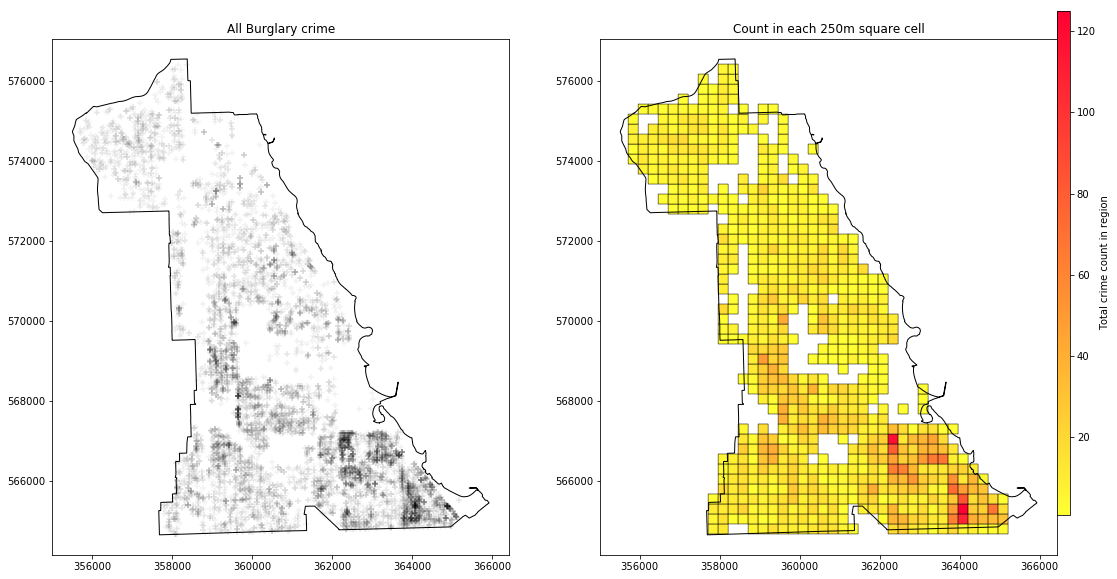

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(18,10))

ax[0].scatter(*points_south_side.coords, marker="+", alpha=0.05, color="Black")
ax[0].set_aspect(1)
ax[0].set_title("All Burglary crime")

pred = open_cp.naive.CountingGridKernel(250)
pred.data = points_south_side
risk = pred.predict()
matrix = np.ma.masked_where(risk.intensity_matrix==0, risk.intensity_matrix)
mappable = ax[1].pcolor(*risk.mesh_data(), matrix, cmap=yellow_to_red, edgecolor="black", linewidth=0.5)
ax[1].set_title("Count in each 250m square cell")
cax = fig.add_axes([0.9, 0.2, 0.01, 0.7])
cbar = fig.colorbar(mappable, orientation="vertical", cax=cax)
cbar.set_label("Total crime count in region")
xmin, ymin, xmax, ymax = south_side.bounds
for a in ax:
    a.add_patch(descartes.PolygonPatch(south_side, fc="none", ec="Black"))
    a.set(xlim=[xmin-500, xmax+500], ylim=[ymin-500, ymax+500])
    a.set_aspect(1)

# Covariance

For KDE applications, it is interesting to think about the covariance matrix of the data.  More precisely, the common approach to KDE is to first apply a [Whitening transformation](https://en.wikipedia.org/wiki/Whitening_transformation) to the data, fit a KDE with a radially symmetric kernel, and then transform back.

In [9]:
import scipy.linalg

array([[  2.47984550e-04,   7.64470621e-05],
       [  0.00000000e+00,   9.89700394e-05]])

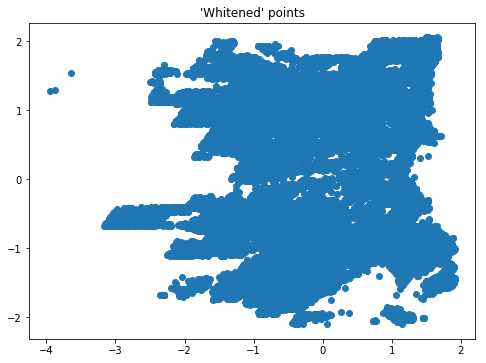

In [10]:
S = np.cov(points.coords)
S = scipy.linalg.inv(S)
S = scipy.linalg.cholesky(S)
x = points.coords - np.mean(points.coords, axis=1)[:,None]
x = np.dot(S, x)

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(*x)
ax.set_aspect(1)
ax.set(title="'Whitened' points")

S

array([[ 0.00062464,  0.00029867],
       [ 0.        ,  0.00034718]])

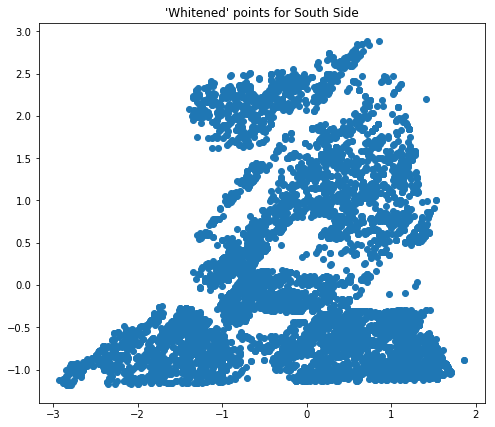

In [11]:
S = np.cov(points_south_side.coords)
S = scipy.linalg.inv(S)
S = scipy.linalg.cholesky(S)
x = points_south_side.coords - np.mean(points_south_side.coords, axis=1)[:,None]
x = np.dot(S, x)

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(*x)
ax.set_aspect(1)
ax.set(title="'Whitened' points for South Side")

S

# Using a masked grid

When we consider "coverage levels" we naturally want to intersect our grid with the outline of the geographic region of interest.

In [12]:
grid = open_cp.data.Grid(xsize=250, ysize=250, xoffset=0, yoffset=0)
masked_grid = open_cp.geometry.mask_grid_by_intersection(south_side, grid)

grid = open_cp.data.Grid(xsize=250, ysize=250, xoffset=125, yoffset=125)
masked_grid_off = open_cp.geometry.mask_grid_by_intersection(south_side, grid)

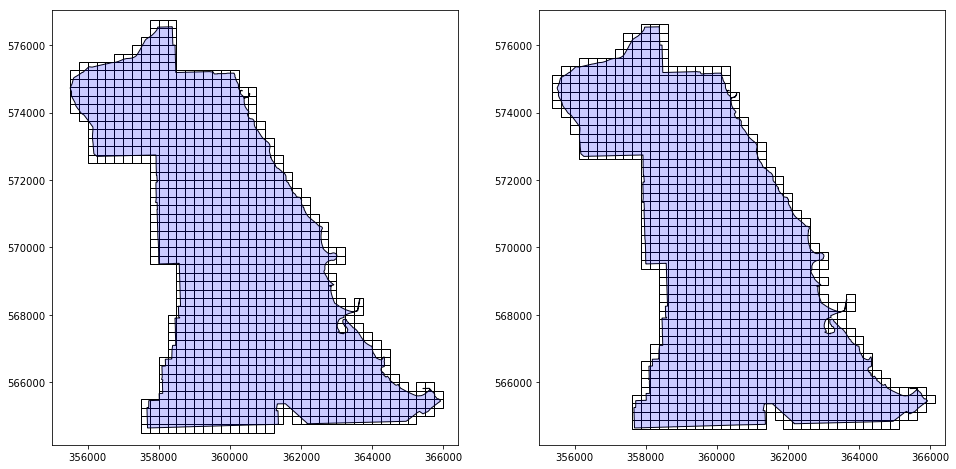

In [13]:
fig, ax  = plt.subplots(ncols=2, figsize=(16,8))

for a in ax:
    a.add_patch(descartes.PolygonPatch(south_side, fc="none", ec="Black"))
    a.add_patch(descartes.PolygonPatch(south_side, fc="Blue", ec="none", alpha=0.2))
    xmin, ymin, xmax, ymax = south_side.bounds
    a.set(xlim=[xmin-500,xmax+500], ylim=[ymin-500,ymax+500])

pc = open_cp.plot.patches_from_grid(masked_grid)
ax[0].add_collection(matplotlib.collections.PatchCollection(pc, facecolor="None", edgecolor="black"))
pc = open_cp.plot.patches_from_grid(masked_grid_off)
ax[1].add_collection(matplotlib.collections.PatchCollection(pc, facecolor="None", edgecolor="black"))
None

# The `common` package

For use in other notebooks, we put some setup into `common.py`.  

We shall follow Adepeju, Rosser and Cheng and:
- Data in just Chicago South side
- Burglary data
- From 1st March 2011 to 6th January 2012
- Evaluate 28th September 2011 – 6th January 2012